In [1]:
import torch
import numpy as np
from typing import List, Tuple
import py3Dmol
from esm.pretrained import ESM3_sm_open_v0
from esm.utils.structure.protein_chain import ProteinChain
from esm.utils.structure.aligner import Aligner
from esm.sdk.api import ESMProtein, GenerationConfig, ESM3InferenceClient
from esm.tokenization import EsmSequenceTokenizer
from esm.models.esm3 import ESM3
from transformers import EsmTokenizer, EsmForSequenceClassification
from peft import PeftModelForSequenceClassification, PeftConfig
from huggingface_hub import snapshot_download
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

%set_env TOKENIZERS_PARALLELISM=false

from tqdm import tqdm
tqdm.disable = True

env: TOKENIZERS_PARALLELISM=false


In [2]:
adapter_names = [
    'SaProtHub/Model-EYFP-650M',
    'SaProtHub/Model-Fluorescence-650M'
]
configs = [
    {'name': 'SaProtHub/Model-EYFP-650M', 'config': PeftConfig.from_pretrained('SaProtHub/Model-EYFP-650M')},
    {'name': 'SaProtHub/Model-Fluorescence-650M', 'config': PeftConfig.from_pretrained('SaProtHub/Model-Fluorescence-650M')}
]
base_model_name = "westlake-repl/SaProt_650M_AF2"
base_model = EsmForSequenceClassification.from_pretrained(base_model_name, num_labels=1)

saprot_model = PeftModelForSequenceClassification(
    model=base_model,
    peft_config=configs[0]['config'],
    adapter_name=configs[0]['name'],
)

for config in configs[1:]:
    saprot_model.add_adapter(config['name'], config['config'])


In [8]:
saprot_model.set_adapter("SaProtHub/Model-EYFP-650M")

In [7]:
config = PeftConfig.from_pretrained('SaProtHub/Model-Fluorescence-650M')

In [8]:
saprot_yfp_model.add_adapter('fluor', config)

In [12]:
saprot_yfp_model.set_adapter('default')

In [3]:

def setup_models():
    # Initialize ESM and SaProt models
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # ESM3 model
    esm_model: ESM3InferenceClient = ESM3.from_pretrained("esm3_sm_open_v1").to(device)
    esm_tokenizer = EsmSequenceTokenizer()
    
    
    # SaProt YFP model
    base_model_name = "westlake-repl/SaProt_650M_AF2"
    yfp_adapter_input = "SaProtHub/Model-EYFP-650M"
    yfp_adapter_path = snapshot_download(repo_id=yfp_adapter_input, repo_type="model")
    base_model_yfp = EsmForSequenceClassification.from_pretrained(base_model_name, num_labels=1)
    saprot_yfp_model = PeftModelForSequenceClassification.from_pretrained(base_model_yfp, yfp_adapter_path)
    
    # SaProt Fluorescence model
    fluor_adapter_input = 'SaProtHub/Model-Fluorescence-650M'
    fluor_adapter_path = snapshot_download(repo_id=fluor_adapter_input, repo_type="model")
    base_model_fluor = EsmForSequenceClassification.from_pretrained(base_model_name, num_labels=1)
    saprot_fluor_model = PeftModelForSequenceClassification.from_pretrained(base_model_fluor, fluor_adapter_path)
    
    saprot_tokenizer = EsmTokenizer.from_pretrained(base_model_name)
    
    saprot_yfp_model.to(device)
    saprot_fluor_model.to(device)
    
    return {
        'esm': esm_model,
        'esm_tokenizer': esm_tokenizer,
        'saprot_yfp': saprot_yfp_model,
        'saprot_fluor': saprot_fluor_model,
        'saprot_tokenizer': saprot_tokenizer
    }

def create_prompt(sequence: str, coords: torch.Tensor, sequence_fixed_indices: List[int], structure_fixed_indices: List[int], mask_fraction: float) -> ESMProtein:
    # Create masked prompt for ESM
    num_residues = len(sequence)
    num_to_mask = int(num_residues * mask_fraction)
    all_indices = list(range(num_residues))
    mask_indices = np.random.choice([i for i in all_indices if i not in sequence_fixed_indices and i not in structure_fixed_indices], num_to_mask, replace=False)
    
    masked_sequence = list(sequence)
    masked_coords = coords.clone()
    
    for idx in mask_indices:
        masked_sequence[idx] = '_'
        masked_coords[idx, :, :] = torch.full_like(masked_coords[idx, :, :], float('nan'))
    
    for idx in sequence_fixed_indices:
        masked_sequence[idx] = sequence[idx]
    
    for idx in structure_fixed_indices:
        masked_coords[idx, :, :] = coords[idx, :, :]
    
    return ESMProtein(sequence=''.join(masked_sequence), coordinates=masked_coords)

def generate_variants(model: ESM3InferenceClient, prompts: List[ESMProtein], configs: List[GenerationConfig]) -> List[ProteinChain]:
    # Generate variants using ESM
    variants = []
    for prompt, config in tqdm(zip(prompts, configs), total=len(prompts)):
        # Generate sequence
        variant_sequence = model.generate(prompt, config)
        
        # Generate structure
        structure_config = GenerationConfig(track="structure", num_steps=config.num_steps, temperature=config.temperature)
        variant = model.generate(variant_sequence, structure_config)
        
        # Convert ESMProtein to ProteinChain
        variant_chain = variant.to_protein_chain()
        variants.append(variant_chain)
    
    return variants

def evaluate_variants(variants: List[ProteinChain], ref_sequence: str, models: dict, ref_chain: ProteinChain, seed_sequence:str) -> pd.DataFrame:
    # Compute all evaluation metrics
    results = []
    
    for i, variant in enumerate(variants):
        seq_identity = calculate_sequence_identity(variant.sequence, ref_sequence)
        chromophore_rmsd = calculate_template_rmsd(variant, ref_chain, [64, 65, 66])
        template_helix_rmsd = calculate_template_rmsd(variant, ref_chain, list(range(57, 71)))
        pseudo_perplexity = calculate_pseudo_perplexity(models['esm'], variant.sequence)
        n_gram_score = calculate_n_gram_score(variant.sequence)
        
        # SaProt model evaluations
        sa_sequence = ''.join([aa + '#' for aa in variant.sequence]) + '#'
        inputs = models['saprot_tokenizer'](sa_sequence, return_tensors="pt").to(models['saprot_yfp'].device)
        
        with torch.no_grad():
            yfp_score = models['saprot_yfp'](**inputs).logits.item()
            fluor_score = models['saprot_fluor'](**inputs).logits.item()
        
        # Compute diffs and mutation counts
        diff = sequence_diff(ref_sequence, variant.sequence)
        n_mutations = len(diff.split('/')) if diff else 0
        
        results.append({
            "name": f'variant_{i}',
            "sequence": variant.sequence,
            "seq_identity": seq_identity,
            "chromophore_rmsd": chromophore_rmsd,
            "template_helix_rmsd": template_helix_rmsd,
            "pseudo_perplexity": pseudo_perplexity,
            "n_gram_score": n_gram_score,
            "yfp_model_score": yfp_score,
            "fluor_model_score": fluor_score,
            "composite_score": (yfp_score + fluor_score*0.5) / 2,
            "diff": diff,
            "n_mutations": n_mutations,
            "seed_sequence": seed_sequence
        })
    
    return pd.DataFrame(results)

def filter_and_select_diverse_set(variants_df: pd.DataFrame, n_select: int = 10) -> List[str]:
    # Sort by YFP and fluorescence scores
    sorted_df = variants_df.sort_values(['composite_score'], ascending=False)
    
    # Select top variants ensuring diversity
    selected_variants = []
    for _, variant in sorted_df.iterrows():
        if len(selected_variants) >= n_select:
            break
        # Check if the variant is diverse enough from already selected ones
        if all(calculate_sequence_identity(variant['sequence'], selected) < 0.95 for selected in selected_variants):
            selected_variants.append(variant['sequence'])
    
    return selected_variants

# Helper functions

def calculate_sequence_identity(seq1: str, seq2: str) -> float:
    assert len(seq1) == len(seq2), "Sequences must be of equal length"
    identical = sum(a == b for a, b in zip(seq1, seq2))
    return identical / len(seq1)

def calculate_template_rmsd(variant: ProteinChain, template: ProteinChain, residues: List[int]) -> float:
    aligner = Aligner(variant, template)
    return aligner.rmsd

def calculate_pseudo_perplexity(model: ESM3_sm_open_v0, sequence: str) -> float:
    tokenizer = EsmSequenceTokenizer()
    tokens = torch.tensor([tokenizer.encode(sequence)]).to("cuda")
    with torch.no_grad():
        output = model(sequence_tokens=tokens)
    log_probs = torch.log_softmax(output.sequence_logits, dim=-1)
    token_log_probs = log_probs[0, torch.arange(len(sequence)), tokens[0, 1:-1]]
    return torch.exp(-token_log_probs.mean()).item()

def calculate_n_gram_score(sequence: str, n: int = 3) -> float:
    from collections import Counter
    ngrams = [sequence[i:i+n] for i in range(len(sequence)-n+1)]
    counts = Counter(ngrams)
    return -sum(count * np.log(count/len(ngrams)) for count in counts.values()) / len(ngrams)

def sequence_diff(ref: str, query: str) -> str:
    diff = []
    for i, (r, q) in enumerate(zip(ref, query)):
        if r != q:
            diff.append(f"{r}{i+1}{q}")
    return '/'.join(diff)

def pad_coords(coords, start_pad, end_pad):
    return torch.cat([
        torch.full((start_pad, 37, 3), float('nan')), 
        coords, 
        torch.full((end_pad, 37, 3), float('nan'))
        ], dim=0)

def adjust_masking_rate(iteration, initial_rate=0.8, decay_factor=0.8, floor_rate=0.01):
    return max(initial_rate * (decay_factor ** iteration), floor_rate)



In [ ]:


def main_loop(num_iterations: int, variants_per_iteration: int, n_select: int = 10):
    # Setup
    models = setup_models()
    seeds = [ref_sequence]  # Start with the reference sequence
    all_variants_df = pd.DataFrame()

    for iteration in tqdm(range(num_iterations), desc="Iterations"):
        masking_rate = adjust_masking_rate(iteration)
        
        # Generate prompts
        prompts = []
        seed_tracking = []  # To keep track of which seed was used for each prompt
        for seed in seeds:
            for _ in range(variants_per_iteration // len(seeds)):
                prompts.append(create_prompt(
                    seed, 
                    padded_coords, 
                    sequence_fixed_indices, 
                    structure_fixed_indices, 
                    masking_rate
                ))
                seed_tracking.append(seed)
        
        # Generate variants
        configs = [
            GenerationConfig(
                track="sequence",
                num_steps=int(len(ref_sequence) * masking_rate),
                # temperature=0.1
            ) 
            for _ in range(len(prompts))
        ]
        variants = generate_variants(models['esm'], prompts, configs)
        
        # Evaluate variants
        variants_df = evaluate_variants(variants, ref_sequence, models, padded_ref_chain, seed_tracking)
        
        # Add iteration number and append to all_variants_df
        variants_df['iteration'] = iteration
        all_variants_df = pd.concat([all_variants_df, variants_df], ignore_index=True)
        
        # Filter and select diverse set for next iteration
        seeds = filter_and_select_diverse_set(variants_df, n_select)
        
        # Print some stats
        print(f"\nIteration {iteration} stats:")
        print(f"Average YFP score: {variants_df['yfp_model_score'].mean():.4f}")
        print(f"Average Fluorescence score: {variants_df['fluor_model_score'].mean():.4f}")
        print(f"Average number of mutations: {variants_df['n_mutations'].mean():.2f}")
        
    return all_variants_df



In [7]:
0.8 * 0.8 ** 5

0.2621440000000001

In [4]:

# Initialization

ref_sequence = 'MVSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFGYGLQCFARYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSYQSALSKDPNEKRDHMVLLEFVTAAGITLGMDELYK'

# Load YFP template
pdb_id = "1YFP"  # Enhanced Yellow Fluorescent Protein
# pdb_id = "1QY3"
chain_id = "A"
ref_chain = ProteinChain.from_rcsb(pdb_id, chain_id)

ref_pdb_start = ref_chain.residue_index[0] # pad this much at the front
ref_pdb_end = ref_chain.residue_index[-1]
end_padding = len(ref_sequence) - ref_pdb_end + 2

coords = torch.tensor(ref_chain.atom37_positions)
ref_sequence_beginning = ref_sequence[:ref_pdb_start]
ref_sequence_ending = ref_sequence[ref_pdb_end:]
padded_coords = pad_coords(coords, ref_pdb_start, end_padding)
padded_ref_chain = ProteinChain.from_atom37(padded_coords)


# fixed positions
positions = [1, 62, 65, 66, 67, 96, 222]
sequence_fixed_indices = [position for position in positions]
structure_fixed_indices = list(range(58, 72)) + [96, 222]

# main loop here


num_iterations = 60
variants_per_iteration = 200
n_select = 10

models = setup_models()
seeds = [ref_sequence]  # Start with the reference sequence
all_variants_df = pd.DataFrame()


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

/home/naka/code/modal-esm/modal-esm/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at westlake-repl/SaProt_650M_AF2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at westlake-repl/SaProt_650M_AF2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'esm.contact_head.regression.bias', 'esm.contact_head.regression.weight', 'esm.embeddings.position_embeddings.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:

for iteration in tqdm(range(num_iterations), desc="Iterations"):
    masking_rate = adjust_masking_rate(iteration)
    
    # Generate prompts
    prompts = []
    seed_tracking = []  # To keep track of which seed was used for each prompt
    for seed in seeds:
        for _ in range(variants_per_iteration // len(seeds)):
            prompts.append(create_prompt(
                seed, 
                padded_coords, 
                sequence_fixed_indices, 
                structure_fixed_indices, 
                masking_rate
            ))
            seed_tracking.append(seed)
    
    # Generate variants
    configs = [
        GenerationConfig(
            track="sequence",
            num_steps=int(len(ref_sequence) * masking_rate),
            # temperature=0.1
        ) 
        for _ in range(len(prompts))
    ]
    break
    variants = generate_variants(models['esm'], prompts, configs)
    
    # Evaluate variants
    variants_df = evaluate_variants(variants, ref_sequence, models, padded_ref_chain, seed_tracking)
    
    # Add iteration number and append to all_variants_df
    variants_df['iteration'] = iteration
    all_variants_df = pd.concat([all_variants_df, variants_df], ignore_index=True)
    
    # Filter and select diverse set for next iteration
    seeds = filter_and_select_diverse_set(variants_df, n_select)
    
    # Print some stats
    print(f"\nIteration {iteration} stats:")
    print(f"Average YFP score: {variants_df['yfp_model_score'].mean():.4f}")
    print(f"Average Fluorescence score: {variants_df['fluor_model_score'].mean():.4f}")
    print(f"Average number of mutations: {variants_df['n_mutations'].mean():.2f}")



Iterations:   0%|          | 0/60 [00:00<?, ?it/s]


In [8]:
x = prompts[0]

In [10]:
c = x.to_protein_chain()

In [ ]:
c.to_pro

In [12]:
models['esm'].encode(x)

ESMProteinTensor(sequence=tensor([ 0, 32,  7, 32, 32,  6, 32, 32, 32, 32, 32, 32, 32, 32, 32, 12, 32, 32,
         9, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,  6, 32,
        32, 32, 32, 11, 32, 32, 32, 32, 32, 32, 32, 18, 32, 32, 11, 32, 32, 32,
        32, 14, 32, 14, 32, 14, 11,  4,  7, 11, 11, 18,  6, 19,  6,  4, 16, 23,
        18, 32, 32, 19, 14, 32, 32, 32, 15, 32, 32, 32, 32, 32, 32, 32,  5, 20,
        32, 32, 32, 19, 32, 32,  9, 10, 32, 32, 32, 32, 32, 32, 32, 32, 32, 19,
        32, 32, 32,  5,  9, 32, 32, 18, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 32, 32, 32, 13,  6, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 32, 21, 17, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 32, 32, 18, 32, 32, 32, 32, 32, 32,  9, 32, 32, 32, 32, 32, 32,
        32, 13, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
        32, 32, 21, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14, 32, 32, 32,
        32, 32


Final stats:
Total variants generated: 60000
Best YFP score: 1.2020
Best Fluorescence score: 2.5713


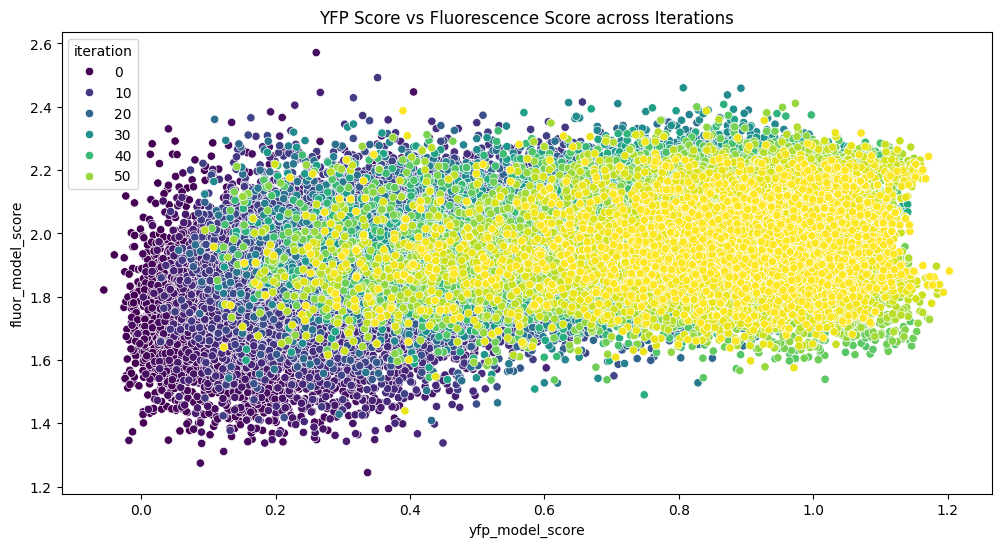

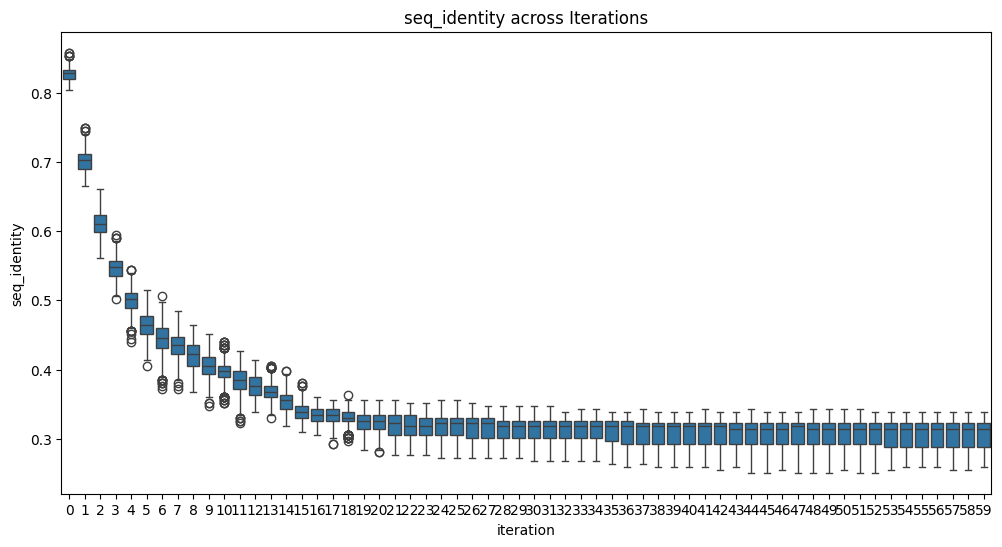

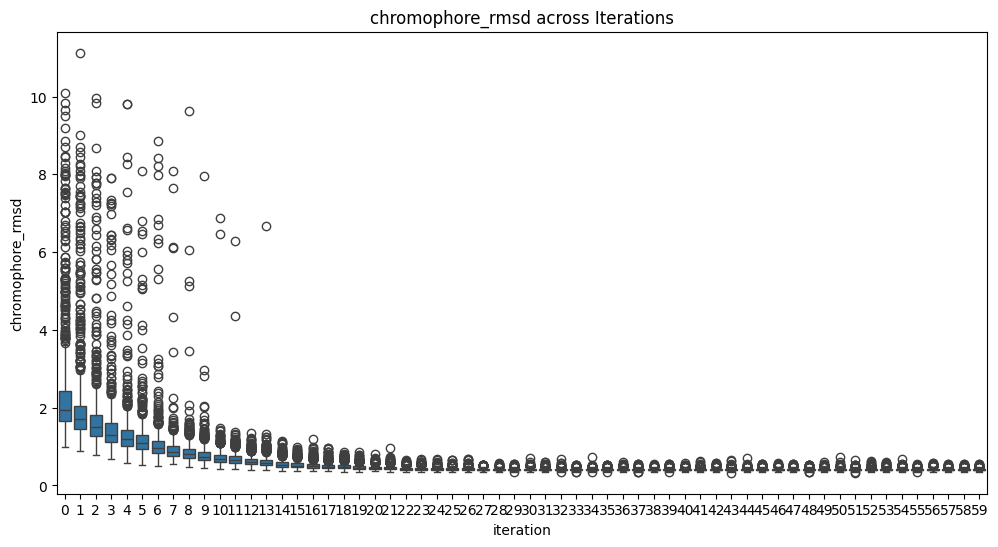

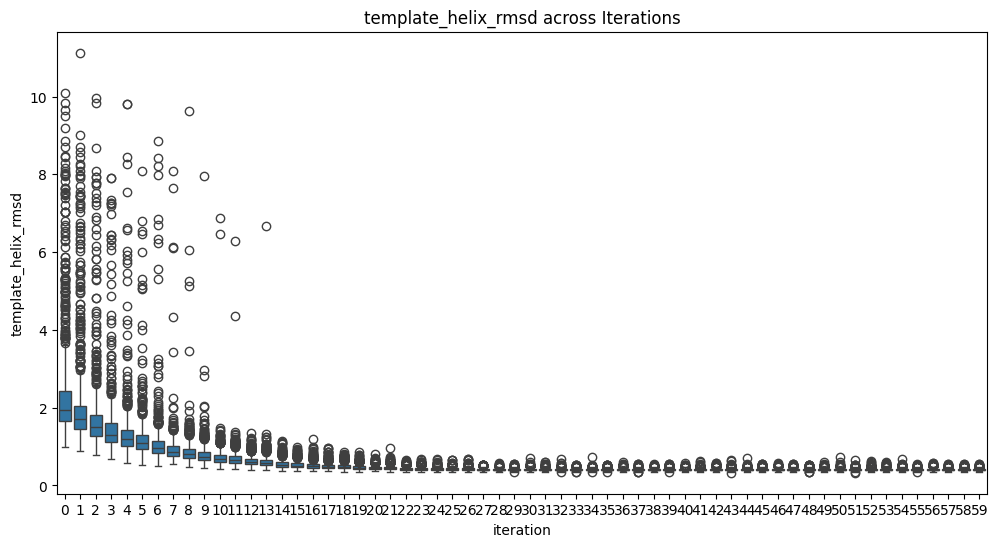

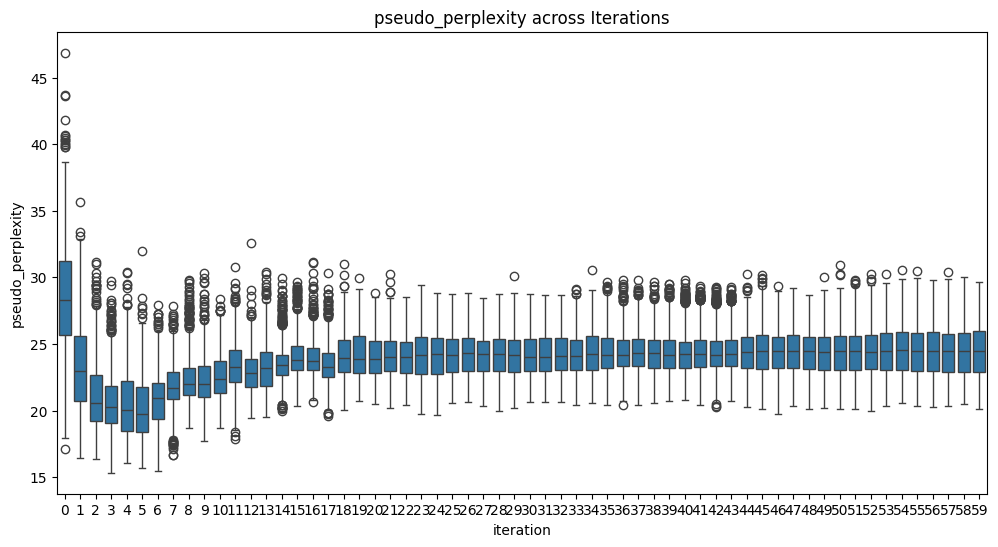

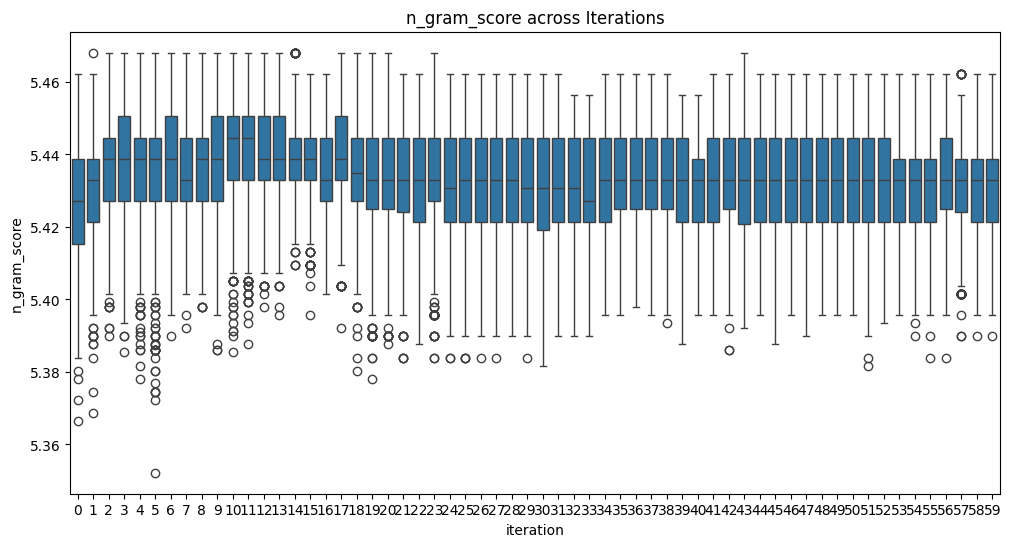

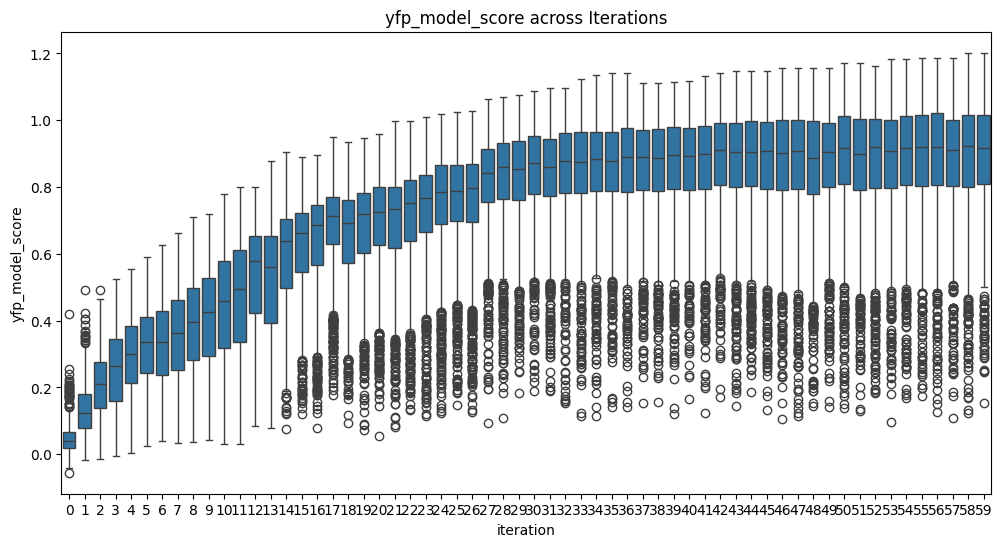

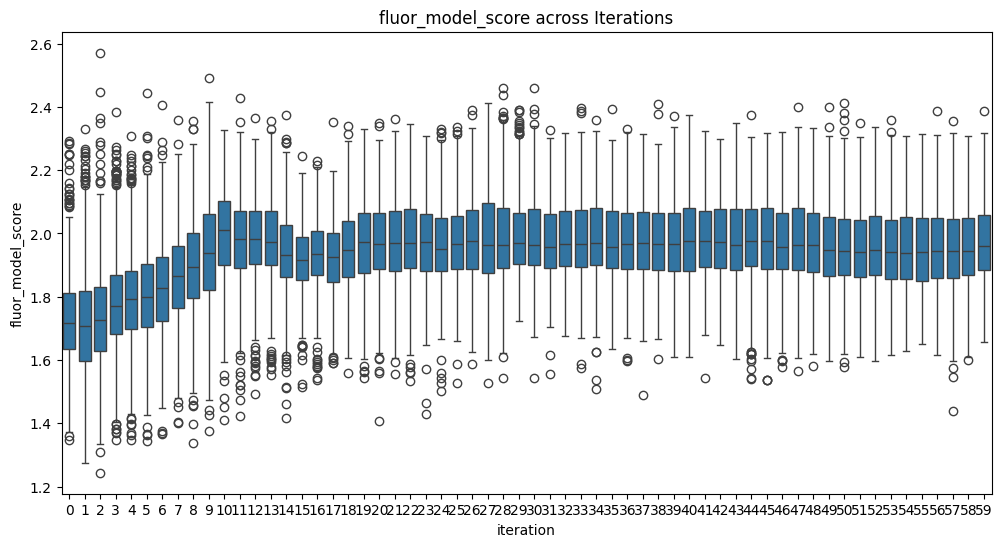

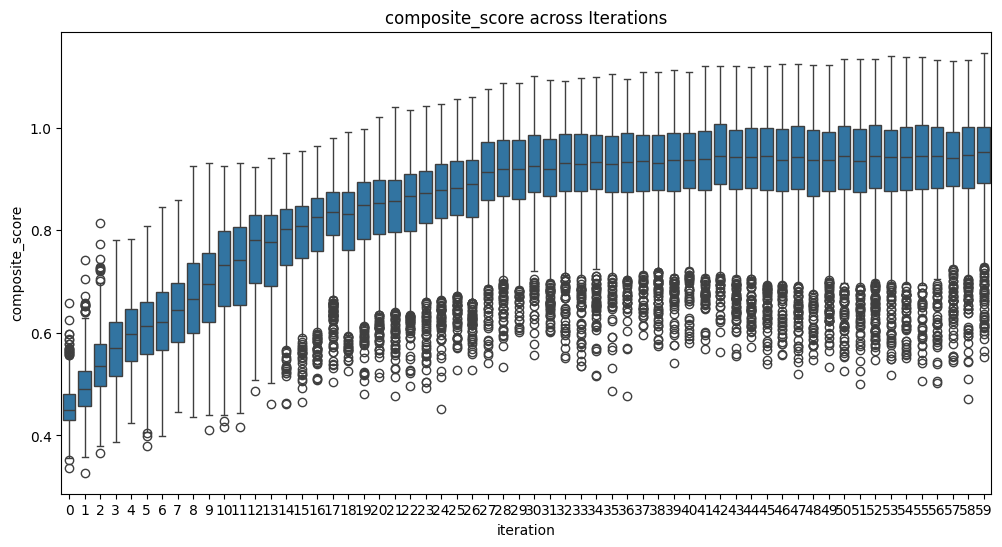

In [ ]:
# Save results

# Print final stats
print("\nFinal stats:")
print(f"Total variants generated: {len(all_variants_df)}")
print(f"Best YFP score: {all_variants_df['yfp_model_score'].max():.4f}")
print(f"Best Fluorescence score: {all_variants_df['fluor_model_score'].max():.4f}")
    
    # Optionally, visualize results
    
plt.figure(figsize=(12, 6))
sns.scatterplot(data=all_variants_df, x='yfp_model_score', y='fluor_model_score', hue='iteration', palette='viridis')
plt.title('YFP Score vs Fluorescence Score across Iterations')

metrics = ['seq_identity', 'chromophore_rmsd', 'template_helix_rmsd', 'pseudo_perplexity', 'n_gram_score', 'yfp_model_score', 'fluor_model_score', 'composite_score']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=all_variants_df, x='iteration', y=metric)
    plt.title(f'{metric} across Iterations')
    plt.show()
    


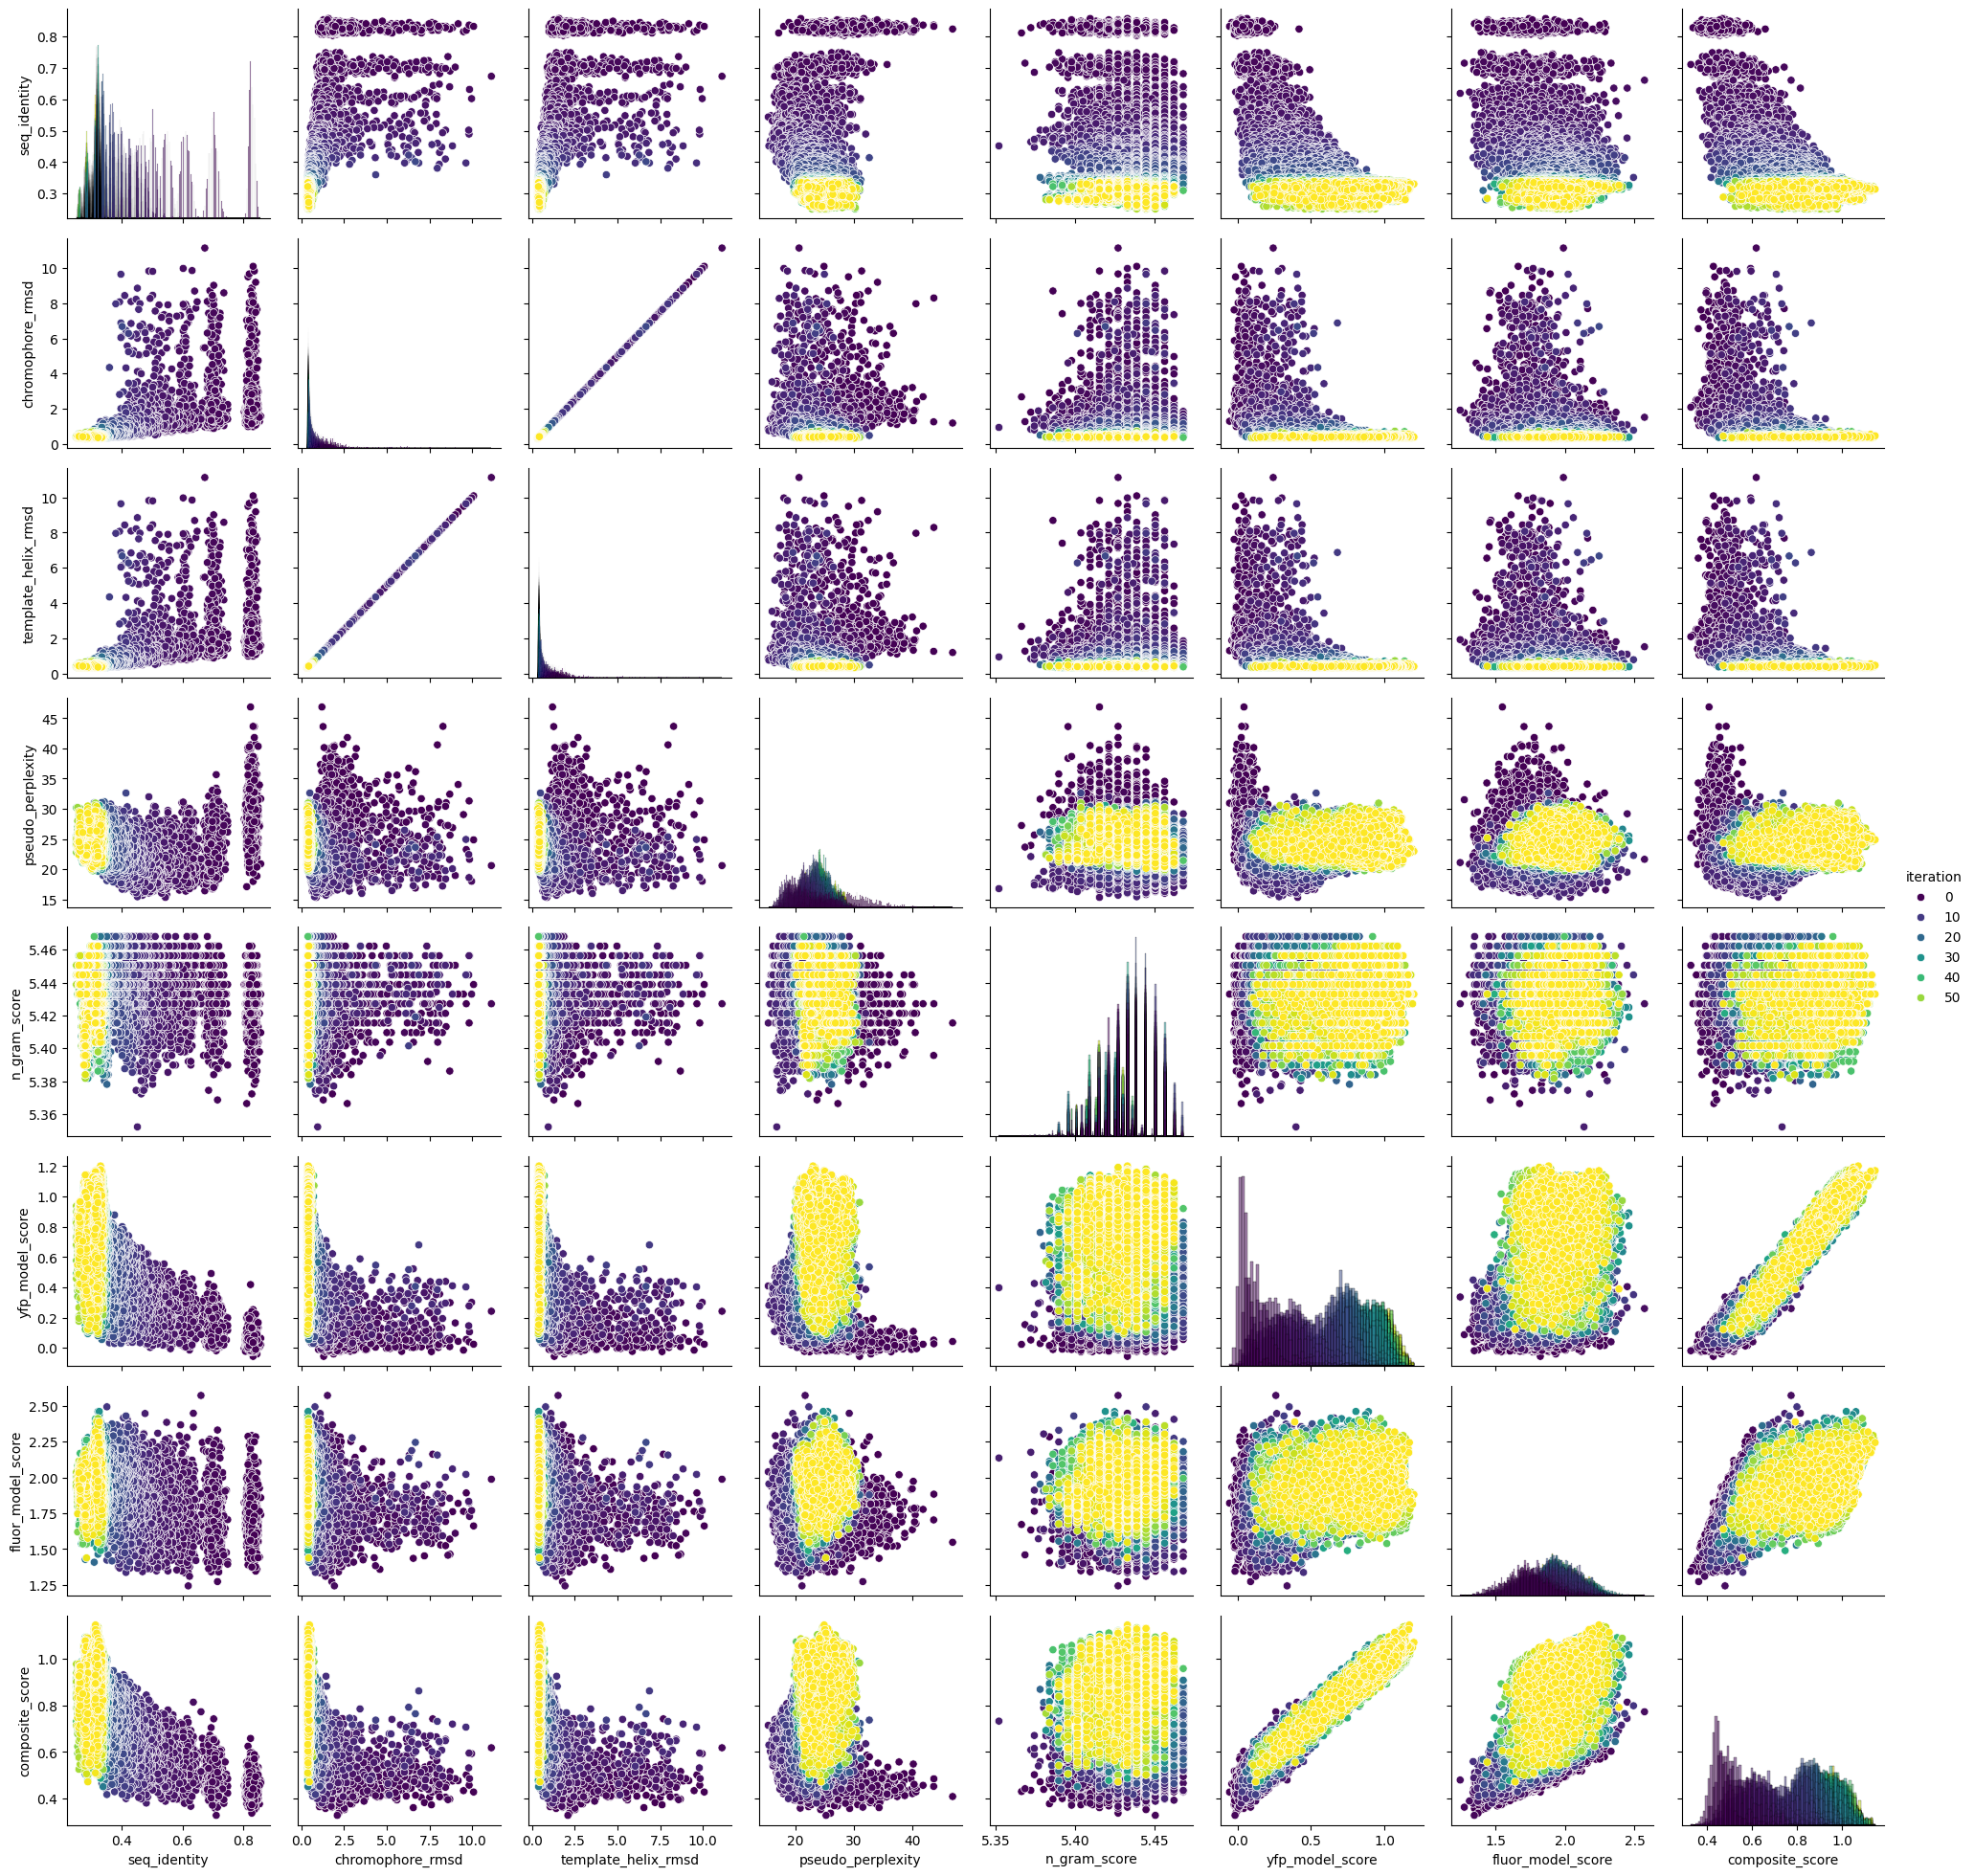

In [ ]:
# Create a PairGrid colored by iteration for the specified metrics
g = sns.PairGrid(all_variants_df, vars=metrics, hue='iteration', palette='viridis')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()


In [ ]:
all_variants_df.to_csv('all_variants.csv')

In [17]:
top_variants = all_variants_df.sort_values(by='composite_score', ascending=False).head(50).iloc[0:10].set_index('name')['sequence'].to_dict()

with open('top_variants.fasta', 'w') as fasta_file:
    for name, sequence in top_variants.items():
        fasta_file.write(f">{name}\n{sequence}\n")


In [ ]:
models = setup_models()
seeds = [ref_sequence]  # Start with the reference sequence
all_variants_df = pd.DataFrame()

for iteration in tqdm(range(num_iterations), desc="Iterations"):
    masking_rate = adjust_masking_rate(iteration)
    
    # Generate prompts
    prompts = []
    seed_tracking = []  # To keep track of which seed was used for each prompt
    for seed in seeds:
        for _ in range(variants_per_iteration // len(seeds)):
            prompts.append(create_prompt(
                seed, 
                padded_coords, 
                sequence_fixed_indices, 
                structure_fixed_indices, 
                masking_rate
            ))
            seed_tracking.append(seed)
    
    # Generate variants
    configs = [
        GenerationConfig(
            track="sequence",
            num_steps=int(len(ref_sequence) * masking_rate),
            # temperature=0.1
        ) 
        for _ in range(len(prompts))
    ]
    variants = generate_variants(models['esm'], prompts, configs)
    
    # Evaluate variants
    variants_df = evaluate_variants(variants, ref_sequence, models, padded_ref_chain, seed_tracking)
    
    # Add iteration number and append to all_variants_df
    variants_df['iteration'] = iteration
    all_variants_df = pd.concat([all_variants_df, variants_df], ignore_index=True)
    
    # Filter and select diverse set for next iteration
    seeds = filter_and_select_diverse_set(variants_df, n_select)